- Check prediction
- fine tune hyperparameter if needed
- Build graph similar to the paper
- what is sample use for ? 

# Regression

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from IPython import display

import seaborn as sns
sns.set()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using GPU" if device.type=="cuda" else "using CPU" )

# super.init ? property ? 

using GPU


## Data

In [2]:
def f(x, sigma=0):
    '''Generate data as in section 5.2 from paper'''
    noise = np.random.normal(0, np.sqrt(sigma), len(x))
    y = x + 0.3*np.sin(2*np.pi*(x + noise)) + 0.3*np.sin(4*np.pi*(x + noise)) 
    return y + noise

In [3]:
class RegressionDataset(Dataset):
    """Custom Pytorch Dataset"""

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        return (self.data[idx][0], self.data[idx][1])

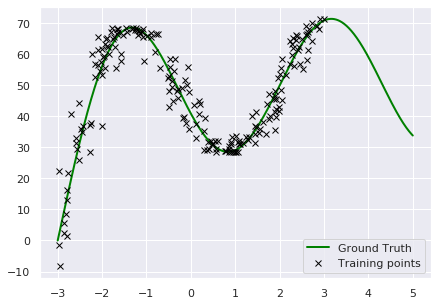

In [6]:
sigma = 0.02**2
train_size = 200
test_size = 10*train_size
bs=10

# create datasets and loaders
X_train = np.random.uniform(0, 6, train_size)
y_train = f(X_train/10, sigma=sigma)*100
X_train = X_train-3
trainset = RegressionDataset(np.vstack([X_train,y_train]).T)   
train_loader = DataLoader(trainset, batch_size=bs, shuffle=True)

X_test = np.linspace(0,8, test_size)
y_test = f(X_test/10,sigma=0)*100
X_test = X_test - 3
testset = RegressionDataset(np.vstack([X_test,y_test]).T)   
test_loader = DataLoader(testset, batch_size=bs, shuffle=False)

# Plot dataset
plt.figure(figsize=(7,5))
#plt.xlim(xmin =-0.2, xmax = 1.)
#plt.ylim(ymin = -0.6, ymax = 1.)
plt.plot(testset.data[:,0],testset.data[:,1], color='green', linewidth=2,label="Ground Truth")
plt.plot(trainset.data[:,0],trainset.data[:,1], 'x', color='black', label='Training points')
plt.legend()
plt.show()

In [7]:
config = {
    #"num_hidden_layers": 2, # hidden layers NN
    #"num_hidden_units": 20, # hidden units NN
    "batch_size": bs,       # batch size
    "epochs": 10,           # epoch 
    "learning_rate": 0.025, # learning rate
    "num_samples": 10,       # num samples for Monte Carlo Approx
    "prior_type": "gaussMixt", # type of prior
    "p": 0.5,              # mixture proba for mixture prior
    #"sigma_p": 1.0, # ou est-ce utilise ? 
    "sigma_p1": torch.cuda.FloatTensor([math.exp(-0)]), # variance for gauss or first variance for mixture
    "sigma_p2": torch.cuda.FloatTensor([math.exp(-6)]),
    "train_size": train_size,
    "test_size": len(test_loader.dataset),
    "num_batches": len(train_loader) # sigma2 = torch.cuda.FloatTensor([math.exp(-6)])
}

## Bayes-By-Backprop

In [8]:
class Gaussian(object):
    
    def __init__(self, mu, rho, device):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1) # to sample epsilon
        self.device = device
        
    @property
    def sigma(self): # to get standard deviation from rho
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self): # to sample w from epsilon, mu and rho
        epsilon = self.normal.sample(self.rho.size()).to(device)
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, w): # return log q(w|theta=(mu,rho))
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((w - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

In [9]:
class Prior(object):
    def __init__(self, sigma1, sigma2=None, p=None, kind="gauss"):
        super().__init__()
        
        if kind not in ["gauss", "gaussMixt"]:
            raise ValueError("Unknown prior type")
            
        if kind=="gaussMixt" and (sigma2 is None or p is None):
            raise ValueError("For Mixture prior, specify p, sigma1 and sigma2")
            
        self.type=kind
            
        self.sigma1 = sigma1
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        
        if self.type=="gaussMixt":
            self.p = p
            self.sigma2 = sigma2
            self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, w): # return log(P(w)) - log of the scale mixture prior
        
        if self.type=="gauss":
            return self.gaussian1.log_prob(w).sum()
        
        else:
            prob1 = torch.exp(self.gaussian1.log_prob(w))
            prob2 = torch.exp(self.gaussian2.log_prob(w))
            return (torch.log(self.p * prob1 + (1-self.p) * prob2)).sum()

In [10]:
class BayesianLinear(nn.Module): # this form one linear layer
    def __init__(self, in_features, out_features, device, config_prior):
        super().__init__()
        
        # layer parameters
        self.in_features = in_features
        self.out_features = out_features
        
        # prior parameters
        self.type_prior = config_prior[0]
        self.sigma1 = config_prior[1]
        if self.type_prior=="gaussMixt":
            self.p = config_prior[-1]
            self.sigma2 = config_prior[-2]
        else:
            self.p, self.sigma2 = None, None
        
        # Weight parameters (init)
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho, device)
        
        # Bias parameters (init)
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho, device)
        
        # Prior distributions
        self.weight_prior = Prior(self.sigma1, self.sigma2, self.p, self.type_prior)
        self.bias_prior = Prior(self.sigma1, self.sigma2, self.p, self.type_prior)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, x, sample=False, calculate_log_probs=False):
        
        if self.training or sample: # step 1-3 article
            weight = self.weight.sample() # sample some weights
            bias = self.bias.sample() # sample some weight bias
        else:
            weight = self.weight.mu
            bias = self.bias.mu
            
        if self.training or calculate_log_probs:
            # compute log p(w)
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            # compute log q(w|theta)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(x, weight, bias)

In [11]:
class BayesianNetwork(nn.Module):
    def __init__(self, device, config_prior):
        super().__init__()
        self.l1 = BayesianLinear(1, 100, device, config_prior)
        #self.l2 = BayesianLinear(20, 20, device, config_prior)
        self.l3 = BayesianLinear(100, 1, device, config_prior)
    
    def forward(self, x, sample=False):
        x = x.view(-1, 1)
        x = F.relu(self.l1(x, sample))
        #x = F.relu(self.l2(x, sample))
        x = self.l3(x, sample)
        return x
    
    def log_prior(self):
        #print(self.l1.log_prior, self.l2.log_prior, self.l3.log_prior)
        #return self.l1.log_prior + self.l2.log_prior + self.l3.log_prior
        return self.l1.log_prior + self.l3.log_prior
    
    def log_variational_posterior(self):
        #return self.l1.log_variational_posterior + self.l2.log_variational_posterior + self.l2.log_variational_posterior
        return self.l1.log_variational_posterior + self.l3.log_variational_posterior
        
    def sample_elbo(self, x, target, device, samples, num_batches, batch_size): # ELBO = f(w,theta) (step 4)
        
        outputs = torch.zeros(samples, batch_size, 1).to(device)
        log_priors = torch.zeros(samples).to(device)
        log_variational_posteriors = torch.zeros(samples).to(device)
        
        for i in range(samples): # Monte Carlo Approximation
            
            outputs[i] = self(x, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
            
        # Get MC mean approximation
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean() 
        
        # p(D|theta) !
        #negative_log_likelihood = F.nll_loss(outputs.mean(0), target, size_average=False)
        #negative_log_likelihood = torch.log(torch.exp(-(target - outputs.mean(0)) ** 2 / 2e-2) / math.sqrt(2e-2 * math.pi)).sum()
        #negative_log_likelihood = (-math.log(math.sqrt(2e-2 * math.pi))- ((target - outputs.mean(0)) ** 2) / 2e-2).sum()
        negative_log_likelihood= (-.5* (target - outputs.mean()) ** 2).sum()   
        loss = (log_variational_posterior - log_prior)/num_batches - negative_log_likelihood
        
        return loss, log_prior, log_variational_posterior, negative_log_likelihood

## Training

In [12]:
config_prior = (config["prior_type"], config["sigma_p1"], config["sigma_p2"], config["p"])
net = BayesianNetwork(device, config_prior).to(device)
optimizer = optim.Adam(net.parameters(), lr=config["learning_rate"])

In [13]:
def train(net, optimizer, epoch, train_loader, device, num_batches, batch_size, samples):
    net.train()
    epoch_loss = [] 
         
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        net.zero_grad()
        loss, log_prior, log_variational_posterior, negative_log_likelihood = net.sample_elbo(data, target, device, samples, num_batches, batch_size)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.cpu().detach().numpy())
        
    return np.mean(epoch_loss)

In [14]:
losses = []
#for epoch in range(config["epochs"]):
for epoch in range(10):
    
    epoch_loss = train(net, 
          optimizer, 
          epoch,
          train_loader, 
          device, 
          config["num_batches"], 
          config["batch_size"], 
          2)
          #config["num_samples"])
        
    losses.append(epoch_loss)

100%|██████████| 20/20 [00:00<00:00, 92.38it/s]


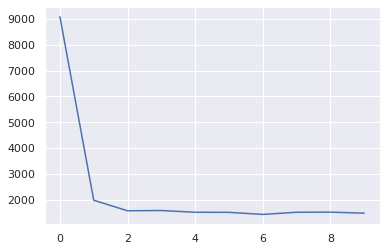

In [15]:
plt.plot(losses);

# Test prediction

tensor([0.1000, 0.1030, 0.1061, 0.1091, 0.1121, 0.1152, 0.1182, 0.1212, 0.1242,
        0.1273, 0.1303, 0.1333, 0.1364, 0.1394, 0.1424, 0.1455, 0.1485, 0.1515,
        0.1545, 0.1576, 0.1606, 0.1636, 0.1667, 0.1697, 0.1727, 0.1758, 0.1788,
        0.1818, 0.1848, 0.1879, 0.1909, 0.1939, 0.1970, 0.2000, 0.2030, 0.2061,
        0.2091, 0.2121, 0.2152, 0.2182, 0.2212, 0.2242, 0.2273, 0.2303, 0.2333,
        0.2364, 0.2394, 0.2424, 0.2455, 0.2485, 0.2515, 0.2545, 0.2576, 0.2606,
        0.2636, 0.2667, 0.2697, 0.2727, 0.2758, 0.2788, 0.2818, 0.2848, 0.2879,
        0.2909, 0.2939, 0.2970, 0.3000, 0.3030, 0.3061, 0.3091, 0.3121, 0.3152,
        0.3182, 0.3212, 0.3242, 0.3273, 0.3303, 0.3333, 0.3364, 0.3394, 0.3424,
        0.3455, 0.3485, 0.3515, 0.3545, 0.3576, 0.3606, 0.3636, 0.3667, 0.3697,
        0.3727, 0.3758, 0.3788, 0.3818, 0.3848, 0.3879, 0.3909, 0.3939, 0.3970,
        0.4000], device='cuda:0')
tensor([[40.6269],
        [40.6191],
        [40.6113],
        [40.6035],
        [4

/home/dimitri/anaconda3/envs/deeplearning/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


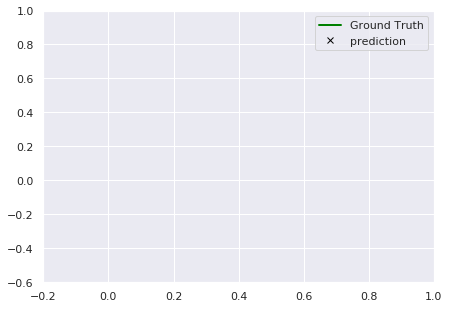

In [16]:
net.eval()
a = np.linspace(0.1,0.4,num=100)
b = torch.tensor(torch.from_numpy(a), dtype=torch.float).to(device)
print(b)
pred = net(b, sample=False)
print(pred)
pred = pred.cpu().detach().numpy().reshape(-1)

# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmin =-0.2, xmax = 1.)
plt.ylim(ymin = -0.6, ymax = 1.)
plt.plot(testset.data[:,0],testset.data[:,1], color='green', linewidth=2,label="Ground Truth")
plt.plot(a,pred, 'x', color='black', label='prediction')
plt.legend()
plt.show()

# Try 2 

In [2]:
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


class BNNLayer(nn.Module):
    NegHalfLog2PI = -.5 * math.log(2.0 * math.pi)
    softplus = lambda x: math.log(1 + math.exp(x))

    def __init__(self, n_input, n_output, activation, prior_mean, prior_rho):
        assert activation in {'relu', 'softmax', 'none'}, 'Activation Type Not Found'

        super(BNNLayer, self).__init__()

        # Instantiate a large Gaussian block to sample from, much faster than generating random sample every time
        self._gaussian_block = np.random.randn(10000)

        self.n_input = n_input
        self.n_output = n_output

        self.W_mean = nn.Parameter(torch.ones((n_input, n_output)) * prior_mean)
        self.W_rho = nn.Parameter(torch.ones(n_input, n_output) * prior_rho)

        self.b_mean = nn.Parameter(torch.ones(1, n_output) * prior_mean)
        self.b_rho = nn.Parameter(torch.ones(1, n_output) * prior_rho)

        self.prior_var = Variable(torch.ones(1, 1) * BNNLayer.softplus(prior_rho) ** 2)

        # Set activation function
        self.act = None
        if activation == 'relu':
            self.act = F.relu
        elif activation == 'softmax':
            self.act = F.softmax

        self._Var = lambda x: Variable(torch.from_numpy(x).type(torch.FloatTensor))

    def forward(self, X, mode):
        assert mode in {'forward', 'MAP', 'MC'}, 'BNNLayer Mode Not Found'

        _shape = (X.size()[0], self.n_output)

        # Z: pre-activation. Local reparam. trick is used.
        Z_Mean = torch.mm(X, self.W_mean) + self.b_mean.expand(*_shape)

        if mode == 'MAP': return self.act(Z_Mean) if self.act is not None else Z_Mean

        Z_Std = torch.sqrt(
            torch.mm(torch.pow(X, 2),
                     torch.pow(F.softplus(self.W_rho), 2)) +
            torch.pow(F.softplus(self.b_rho.expand(*_shape)), 2)
        )

        Z_noise = self._random(_shape)
        Z = Z_Mean + Z_Std * Z_noise

        if mode == 'MC': return self.act(Z) if self.act is not None else Z

        # Stddev for the prior
        Prior_Z_Std = torch.sqrt(
            torch.mm(torch.pow(X, 2),
                     self.prior_var.expand(self.n_input, self.n_output)) +
            self.prior_var.expand(*_shape)
        ).detach()

        # KL[posterior(w|D)||prior(w)]
        layer_KL = self.sample_KL(Z,
                                  Z_Mean, Z_Std,
                                  Z_Mean.detach(), Prior_Z_Std)

        out = self.act(Z) if self.act is not None else Z
        return out, layer_KL

    def _random(self, shape):
        Z_noise = np.random.choice(self._gaussian_block, size=shape[0] * shape[1])
        Z_noise = np.expand_dims(Z_noise, axis=1).reshape(*shape)
        return self._Var(Z_noise)

    @staticmethod
    def log_gaussian(x, mean, std):
        return BNNLayer.NegHalfLog2PI - torch.log(std) - .5 * torch.pow(x - mean, 2) / torch.pow(std, 2)

    @staticmethod
    def sample_KL(x, mean1, std1, mean2, std2):
        log_prob1 = BNNLayer.log_gaussian(x, mean1, std1)
        log_prob2 = BNNLayer.log_gaussian(x, mean2, std2)
        return (log_prob1 - log_prob2).sum()

In [3]:
import torch
import torch.nn as nn


class BNN(nn.Module):
    def __init__(self, *layers):
        super(BNN, self).__init__()

        self.layers, self.params = [], nn.ParameterList()
        for layer in layers:
            self.layers.append(layer)
            self.params.extend([*layer.parameters()])   # register module parameters

    def forward(self, x, mode):
        if mode == 'forward':
            net_kl = 0
            for layer in self.layers:
                x, layer_kl = layer.forward(x, mode)
                net_kl += layer_kl
            return x, net_kl
        else:
            for layer in self.layers:
                x = layer.forward(x, mode)
            return x

    def Forward(self, x, y, n_samples, type):

        assert type in {'Gaussian', 'Softmax'}, 'Likelihood type not found'

        # Sample N samples and average
        total_kl, total_likelh = 0., 0.
        for _ in range(n_samples):
            out, kl = self.forward(x, mode='forward')

            # Gaussian output (with unit var)
            # lklh = torch.log(torch.exp(-(y - out) ** 2 / 2e-2) / math.sqrt(2e-2 * math.pi)).sum()

            if type == 'Gaussian':
                lklh = (-.5 * (y - out) ** 2).sum()
            else:   # softmax
                lklh = torch.log(out.gather(1, y)).sum()

            total_kl += kl
            total_likelh += lklh

        return total_kl / n_samples, total_likelh / n_samples

    @staticmethod
    def loss_fn(kl, lklh, n_batch):
        return (kl / n_batch - lklh).mean()

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable

plt.style.use('seaborn-paper')

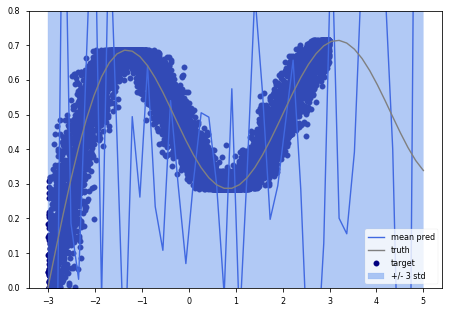

In [99]:
def f(x, sigma=0):
    '''Generate data as in section 5.2 from paper'''
    noise = np.random.normal(0, np.sqrt(sigma), len(x))
    y = x + 0.3*np.sin(2*np.pi*(x + noise)) + 0.3*np.sin(4*np.pi*(x + noise)) 
    return y + noise

sigma = 0.02**2
x = np.random.uniform(0, 6, 10000)
y = f(x/10, sigma=sigma).reshape(-1,1)
x = x-3
x = x.reshape((-1,1))

#x = np.random.uniform(-4, 4, size=20).reshape((-1, 1))
#noise = np.random.normal(0, 9, size=20).reshape((-1, 1))
#y = x ** 3 + noise

Var = lambda x, dtype=torch.FloatTensor: Variable(torch.from_numpy(x).type(dtype))
X = Var(x)
Y = Var(y)

# Initialize network
bnn = BNN(BNNLayer(1, 100, activation='relu', prior_mean=0, prior_rho=0),
          BNNLayer(100, 100, activation='relu', prior_mean=0, prior_rho=0),
          BNNLayer(100, 1, activation='none', prior_mean=0, prior_rho=0))

optim = torch.optim.Adam(bnn.parameters(), lr=1e-3)

# Main training loop
losses = []
for i_ep in range(500):
    kl, lg_lklh = bnn.Forward(X, Y, 1, 'Gaussian')
    loss = BNN.loss_fn(kl, lg_lklh, 1)
    optim.zero_grad()
    loss.backward()
    losses.append(loss.item())
    optim.step()


# Plotting
plt.scatter(x, y, c='navy', label='target')

x_ = np.linspace(0, 8)
#y_ = x_ ** 3
y_ = f(x_/10, sigma=0)
x_ = x_ - 3
X_ = Var(x_).unsqueeze(1)

pred_lst = [bnn.forward(X_, mode='MC').data.numpy().squeeze(1) for _ in range(100)]

pred = np.array(pred_lst).T
pred_mean = pred.mean(axis=1)
pred_std = pred.std(axis=1)

plt.plot(x_, pred_mean, c='royalblue', label='mean pred')
plt.fill_between(x_, pred_mean - 3 * pred_std, pred_mean + 3 * pred_std,
                 color='cornflowerblue', alpha=.5, label='+/- 3 std')

plt.plot(x_, y_, c='grey', label='truth')

plt.legend()
plt.tight_layout()
plt.ylim(0,0.8)
plt.show()

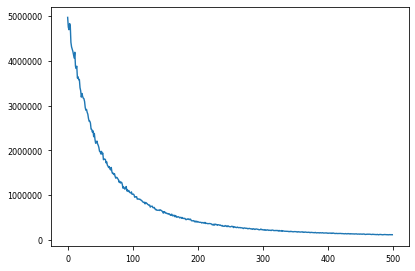

In [100]:
plt.plot(losses)

In [98]:
losses

[51995.15625,
 47863.33984375,
 56005.84765625,
 38638.125,
 48295.90625,
 61704.29296875,
 54103.328125,
 40782.0234375,
 47773.35546875,
 57238.3984375,
 53170.98828125,
 46335.3125,
 40635.68359375,
 42223.79296875,
 38986.73046875,
 48967.421875,
 32819.30859375,
 35316.8046875,
 29852.310546875,
 36428.015625,
 36148.2109375,
 40879.28125,
 48325.0234375,
 30764.359375,
 36888.49609375,
 62765.03125,
 29991.240234375,
 37389.22265625,
 26665.8671875,
 35462.17578125,
 45385.01953125,
 32755.1484375,
 27059.650390625,
 31200.16796875,
 25279.693359375,
 31212.189453125,
 40499.17578125,
 27713.833984375,
 27389.076171875,
 42798.1875,
 24069.625,
 21092.80859375,
 26381.41015625,
 27359.904296875,
 23500.857421875,
 18761.474609375,
 21787.18359375,
 28213.234375,
 23645.857421875,
 24827.64453125,
 22503.978515625,
 14578.740234375,
 21379.5078125,
 24146.55078125,
 22046.80859375,
 20110.236328125,
 24296.326171875,
 17102.890625,
 21074.623046875,
 16543.0234375,
 16961.60351562

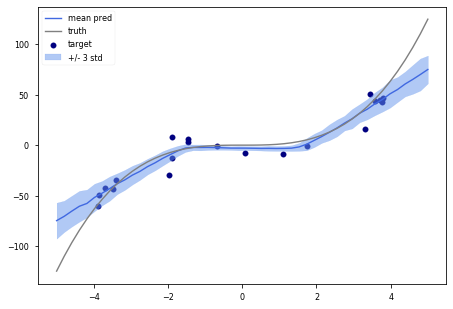

In [27]:
x = np.random.uniform(-4, 4, size=20).reshape((-1, 1))
noise = np.random.normal(0, 9, size=20).reshape((-1, 1))
y = x ** 3 + noise

Var = lambda x, dtype=torch.FloatTensor: Variable(torch.from_numpy(x).type(dtype))
X = Var(x)
Y = Var(y)


if __name__ == '__main__':

    # Initialize network
    bnn = BNN(BNNLayer(1, 100, activation='relu', prior_mean=0, prior_rho=0),
              BNNLayer(100, 1, activation='none', prior_mean=0, prior_rho=0))

    optim = torch.optim.Adam(bnn.parameters(), lr=1e-1)

    # Main training loop
    for i_ep in range(400):
        kl, lg_lklh = bnn.Forward(X, Y, 1, 'Gaussian')
        loss = BNN.loss_fn(kl, lg_lklh, 1)
        optim.zero_grad()
        loss.backward()
        optim.step()

    # Plotting
    plt.scatter(x, y, c='navy', label='target')

    x_ = np.linspace(-5, 5)
    y_ = x_ ** 3
    X_ = Var(x_).unsqueeze(1)

    pred_lst = [bnn.forward(X_, mode='MC').data.numpy().squeeze(1) for _ in range(100)]

    pred = np.array(pred_lst).T
    pred_mean = pred.mean(axis=1)
    pred_std = pred.std(axis=1)

    plt.plot(x_, pred_mean, c='royalblue', label='mean pred')
    plt.fill_between(x_, pred_mean - 3 * pred_std, pred_mean + 3 * pred_std,
                     color='cornflowerblue', alpha=.5, label='+/- 3 std')

    plt.plot(x_, y_, c='grey', label='truth')

    plt.legend()
    plt.tight_layout()
    plt.show()

In [29]:
y.shape

(20, 1)